In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
import itertools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta, time
from tqdm import tqdm_notebook as tqdm

# Exercise 2: Predictive maintenance

This test is based on a laboratory test on a single heat exchanger. The machine is continuously monitored and 6 sensors are read every 2 seconds. While running, the element is subject to a simulated aging.

The goal of this exercise it to predict the Remaining Useful Life (RUL) of a heat exchanger electric motor. It is a classical predictive maintenance problem: sensors installed on a device can be used to predict when the device itself will fail. An alarm can be generated to alert operators. In this example the radiator motor will adapt the speed of the fan to keep the temperature of the outflowing fluid lower below a threshold. If the motor speed goes above a certain level it can sustain damage, we need to try to use sensors data to predict in advance when the motor reaches the critical point. 

The manufacturer reports that the motor can be safely run below 1270 RPM.

<img src="data/rul.png">

The motor is equipped with 6 senors: the pressure and temperature of in- and out-flows, the ambient temperature and the actual speed of the motor. The data have been collected on a test bench.

The summary of the collected data is showed below.

In [29]:
rawdata = pd.read_excel(join("data","rul.xlsx"), 1)
rawdata.head()

Tempo  Temp In  Temp Amb  Press In  Press Out  Fan RPM  \
0 2018-10-15 10:23:21.696     57.5      20.3     10383       9867      644   
1 2018-10-15 10:23:24.288     57.5      20.3     10421       9794      644   
2 2018-10-15 10:23:26.016     57.5      20.3     10425       9817      644   
3 2018-10-15 10:23:27.744     57.5      20.3     10410       9825      643   
4 2018-10-15 10:23:30.336     57.5      20.3     10372       9841      643   

   Temp Out  
0      54.9  
1      54.9  
2      54.9  
3      54.9  
4      54.8

At first we re-index the data to use the `Tempo` variable as the index of the dataframe.

In [30]:
rawdata.set_index("Tempo", inplace=True)

In [31]:
rawdata.head()

Temp In  Temp Amb  Press In  Press Out  Fan RPM  \
Tempo                                                                      
2018-10-15 10:23:21.696     57.5      20.3     10383       9867      644   
2018-10-15 10:23:24.288     57.5      20.3     10421       9794      644   
2018-10-15 10:23:26.016     57.5      20.3     10425       9817      644   
2018-10-15 10:23:27.744     57.5      20.3     10410       9825      643   
2018-10-15 10:23:30.336     57.5      20.3     10372       9841      643   

                         Temp Out  
Tempo                              
2018-10-15 10:23:21.696      54.9  
2018-10-15 10:23:24.288      54.9  
2018-10-15 10:23:26.016      54.9  
2018-10-15 10:23:27.744      54.9  
2018-10-15 10:23:30.336      54.8

<AxesSubplot:xlabel='Tempo'>

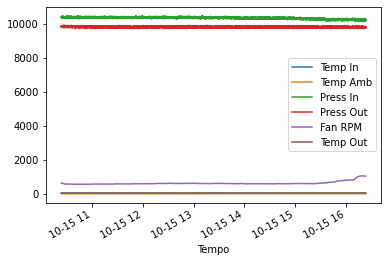

In [33]:
rawdata.plot()

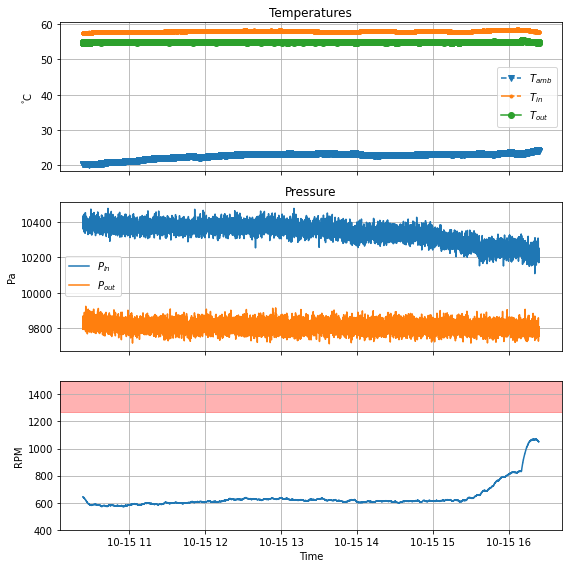

In [6]:
###### Exercise 1 ############
# Make plots of the measurements as a function of time.
##############################
fig, ax = plt.subplots(3, 1, figsize=(8,8), sharex=True)

plt.sca(ax[0])
plt.title("Temperatures")
plt.ylabel(r"$^\degree$C")
#plt.xlabel("Time")
plt.plot(rawdata["Temp Amb"], "v--", label=r"$T_{amb}$")
plt.plot(rawdata["Temp In"], ".-.", label=r"$T_{in}$")
plt.plot(rawdata["Temp Out"], "o-", label=r"$T_{out}$")
plt.grid()
plt.legend()

plt.sca(ax[1])
plt.title("Pressure")
plt.ylabel("Pa")
plt.xlabel("")
plt.plot(rawdata["Press In"], label=r"$P_{in}$")
plt.plot(rawdata["Press Out"], label=r"$P_{out}$")
plt.grid()
plt.legend()
           
plt.sca(ax[2])
plt.plot(rawdata["Fan RPM"])
plt.ylabel("RPM")
plt.xlabel("Time")
plt.axhspan(ymin=1270, ymax=1500, alpha=.3, color="r")
plt.ylim(400,1500)
plt.grid()
plt.tight_layout()
plt.show()

We can see from the plots that the sensor measurements are very noisy, one way to deal with that is to resample the data: 
we replace the measurements at each point with the mean and standard deviation of the measurement calculated in a time interval and build a new dataframe with the resampled data.

In [7]:
### Exercise 3: resample data
### Hint 1: given a dataframe use the function pandas.DataFrame.resample. A one minute resampling interval is represented by rule="1T" label should be "right" (i.e. )
### https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html
### 
### Exercise 3.1: What is the correct value of the paramter called label? Why? Hint: we want to do an analysis that, looking at the past, will predict the future: Given a time interval we want to associate the value at time T as the mean of the measurement for an interval [T-1min, T]...
###
### Hint 2: Given the output of the resample operation, you can aggregate results applying a reduction function, e.g. `mean()` or `std()`
### This will create a new DataFrame with the same columns but with time resampling performed.
####
### Hint 3: The columns of the mean and standard deviations will have the same name of the original dataset, use 
### .add_suffix(a_string) to change the column names.
###
### We want to do the following "pipeline"
### mean_df = <original_data>.resample(....).mean().add_suffix(" mean")
### std_df = ... similar ....
### resampled_df = pd.concat([mean_df, std_df], axis=1) <<< Do you understand this line?

In [38]:
rawdata.resample("1T", label="right").mean().add_suffix(" mean")

Temp In mean  Temp Amb mean  Press In mean  \
Tempo                                                             
2018-10-15 10:24:00     57.500000      20.300000   10395.400000   
2018-10-15 10:25:00     57.600000      20.300000   10391.206897   
2018-10-15 10:26:00     57.600000      20.300000   10398.741935   
2018-10-15 10:27:00     57.600000      20.300000   10376.034483   
2018-10-15 10:28:00     57.600000      20.296774   10373.451613   
...                           ...            ...            ...   
2018-10-15 16:20:00     58.000000      23.986207   10224.620690   
2018-10-15 16:21:00     57.993333      24.010000   10224.700000   
2018-10-15 16:22:00     57.948387      24.103226   10226.806452   
2018-10-15 16:23:00     57.875862      24.200000   10223.206897   
2018-10-15 16:24:00     57.800000      24.100000   10226.409091   

                     Press Out mean  Fan RPM mean  Temp Out mean  
Tempo                                                             
2018-10-15 10:24:00     9832.150000    640.150000      54.845000  
2018-10-15 10:25:00     9837.482759    633.586207      54.851724  
2018-10-15 10:26:00     9834.645161    620.483871      54.825806  
2018-10-15 10:27:00     9831.689655    606.758621      54.827586  
2018-10-15 10:28:00     9848.548387    594.419355      54.832258  
...                             ...           ...            ...  
2018-10-15 16:20:00     9807.862069   1066.862069      54.955172  
2018-10-15 16:21:00     9806.533333   1065.933333      54.943333  
2018-10-15 16:22:00     9802.516129   1068.032258      54.961290  
2018-10-15 16:23:00     9790.551724   1061.482759      54.879310  
2018-10-15 16:24:00     9784.727273   1052.818182      54.854545  

[361 rows x 6 columns]

In [40]:
data1tmean = rawdata.resample("1T", label="right").mean().add_suffix(" mean")
data1tstd = rawdata.resample("1T", label="right").std().add_suffix(" std")
data1t = pd.concat([data1tmean, data1tstd], axis=1)
data1t.head()

Temp In mean  Temp Amb mean  Press In mean  \
Tempo                                                             
2018-10-15 10:24:00          57.5      20.300000   10395.400000   
2018-10-15 10:25:00          57.6      20.300000   10391.206897   
2018-10-15 10:26:00          57.6      20.300000   10398.741935   
2018-10-15 10:27:00          57.6      20.300000   10376.034483   
2018-10-15 10:28:00          57.6      20.296774   10373.451613   

                     Press Out mean  Fan RPM mean  Temp Out mean  Temp In std  \
Tempo                                                                           
2018-10-15 10:24:00     9832.150000    640.150000      54.845000          0.0   
2018-10-15 10:25:00     9837.482759    633.586207      54.851724          0.0   
2018-10-15 10:26:00     9834.645161    620.483871      54.825806          0.0   
2018-10-15 10:27:00     9831.689655    606.758621      54.827586          0.0   
2018-10-15 10:28:00     9848.548387    594.419355      54.832258          0.0   

                     Temp Amb std  Press In std  Press Out std  Fan RPM std  \
Tempo                                                                         
2018-10-15 10:24:00      0.000000     22.642299      20.969339     2.680829   
2018-10-15 10:25:00      0.000000     26.871891      25.582668     3.698622   
2018-10-15 10:26:00      0.000000     22.565413      29.821188     4.056854   
2018-10-15 10:27:00      0.000000     17.961234      28.877949     3.621909   
2018-10-15 10:28:00      0.017961     20.956842      24.800321     3.232895   

                     Temp Out std  
Tempo                              
2018-10-15 10:24:00      0.051042  
2018-10-15 10:25:00      0.063362  
2018-10-15 10:26:00      0.044480  
2018-10-15 10:27:00      0.045486  
2018-10-15 10:28:00      0.047519

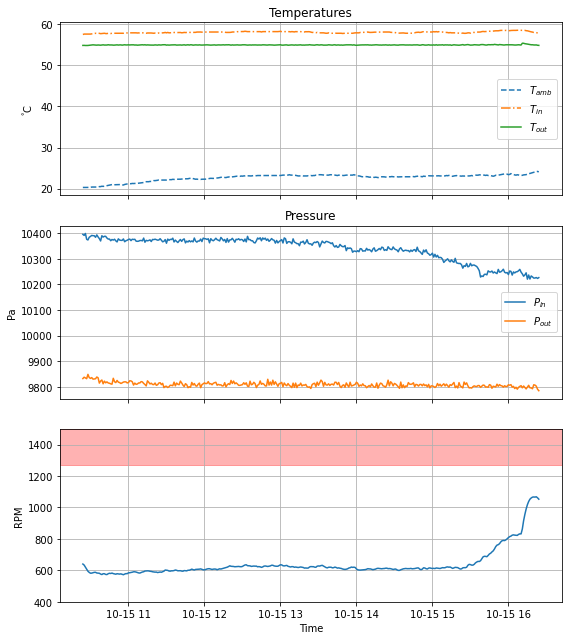

In [41]:
#### Exercise 2
# Repeat plots using the resampled data
#####
fig, ax = plt.subplots(3, 1, figsize=(8,9), sharex=True)

plt.sca(ax[0])
plt.title("Temperatures")
plt.ylabel(r"$^\degree$C")
#plt.xlabel("Time")
plt.plot(data1t["Temp Amb mean"], "--", label=r"$T_{amb}$")
plt.plot(data1t["Temp In mean"], "-.", label=r"$T_{in}$")
plt.plot(data1t["Temp Out mean"], "-", label=r"$T_{out}$")
plt.grid()
plt.legend()

plt.sca(ax[1])
plt.title("Pressure")
plt.ylabel("Pa")
plt.xlabel("")
plt.plot(data1t["Press In mean"], label=r"$P_{in}$")
plt.plot(data1t["Press Out mean"], label=r"$P_{out}$")
plt.grid()
plt.legend()
           
plt.sca(ax[2])
plt.plot(data1t["Fan RPM mean"])
plt.ylabel("RPM")
plt.xlabel("Time")
plt.axhspan(ymin=1270, ymax=1500, alpha=.3, color="r")
plt.ylim(400,1500)
plt.grid()
plt.tight_layout()
plt.show()

# Simple Linear model using RPM
A simple linear model to predict the remaining useful life is implemented. This model uses RPM itself.

In [42]:
from scipy.stats import linregress

The following function predicts the time to failure of an input time series `x`. It is assumed that the input follows a linear model: `linregress` is used to fit the data to a linear model.

In [11]:
#### Exercise 4: Understand this function :-)
# Input x is a array-like 1D variable.
# Note we can consider this as an aggregation function: given an input array, it returns a single value.
rpm_lim = 1270
def predictraise(x):
    n = len(x)
    res = linregress(np.arange(n), x)
    if res.slope>0 and rpm_lim>res.intercept:
        ttf = (rpm_lim-res.intercept)/res.slope
        #return res.slope
        return ttf
    else:
        return np.nan

Here comes the prediction. We use the easiest possible model to predict the variable `Fan RPM mean`: a linear model that uses the previous 2 hours data points to predict the current value of the motor speed.   
To do this, we use the `rolling` functionalities (like the moving average, but instead of an average we use our custom aggregation function)

In [46]:
#### Exercise 5: use the predictraise function to predict TTF of the resampled data.
# Hint 1: use the "rolling" dataframe function.
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html
# 
# At the output can be applayed any aggregation function via the .apply() method
# https://pandas.pydata.org/docs/reference/api/pandas.core.window.rolling.Rolling.apply.html
# return value of the rolling function. E.g.: 
# <>.rolling(...).apply(...., raw=True)
# Use the "raw=True" to convert the data into 1D simple arrays to be passed to the custom function above. 
#
# For the windows parameter: the string "2h" represents the 2 hours interval
# What is the value of min_periods to be used?
# 
# Hint 2: since we are interested only in the "Fan RPM mean" variable you can restrict the aggregation to that column only:
# new_data = <olddata>.rolling(...)[<column_name>].apply(...)  
datafit = data1t.rolling("2h", min_periods=120)["Fan RPM mean"].apply(predictraise,raw=True)
datafit.tail()

Tempo
2018-10-15 16:20:00    264.146375
2018-10-15 16:21:00    254.366091
2018-10-15 16:22:00    245.490186
2018-10-15 16:23:00    237.591006
2018-10-15 16:24:00    230.603708
Freq: T, Name: Fan RPM mean, dtype: float64

In [45]:
data1t.rolling("2h", min_periods=120)["Fan RPM mean"].apply(predictraise, raw=True)

Tempo
2018-10-15 10:24:00           NaN
2018-10-15 10:25:00           NaN
2018-10-15 10:26:00           NaN
2018-10-15 10:27:00           NaN
2018-10-15 10:28:00           NaN
                          ...    
2018-10-15 16:20:00    264.146375
2018-10-15 16:21:00    254.366091
2018-10-15 16:22:00    245.490186
2018-10-15 16:23:00    237.591006
2018-10-15 16:24:00    230.603708
Freq: T, Name: Fan RPM mean, Length: 361, dtype: float64

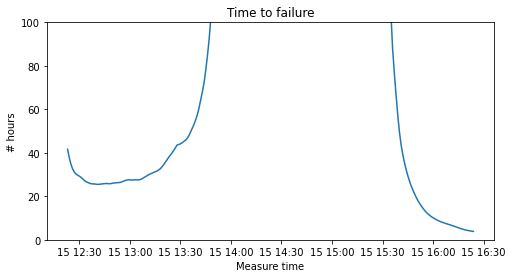

In [47]:
# Exercise 6: Plot and interpret the time to failure
plt.subplots(figsize=(8,4))
plt.plot(datafit/60)
plt.title("Time to failure")
plt.ylabel("# hours")
plt.xlabel("Measure time")
plt.ylim(0,100)
plt.show()

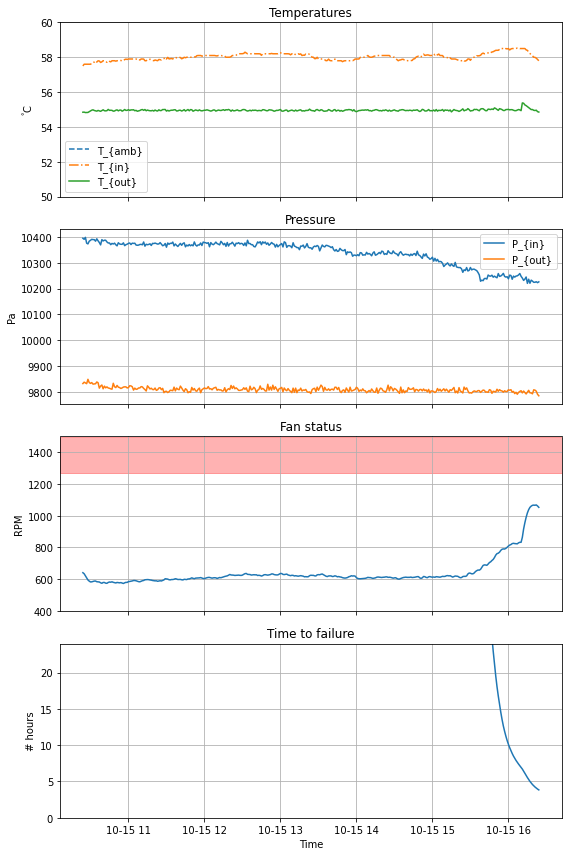

In [48]:
####### Exercise 7 (Optional)
# This is the third time we make these plots: write a function and re-implement Exercise 1 and 2.
# Note that in this case we have an extra plot. So you need to add a switch
fig, ax = plt.subplots(4, 1, figsize=(8,12), sharex=True)

plt.sca(ax[0])
plt.title("Temperatures")
plt.ylabel(r"$^\degree$C")
#plt.xlabel("Time")
plt.plot(data1t["Temp Amb mean"], "--", label=r"T_{amb}")
plt.plot(data1t["Temp In mean"], "-.", label=r"T_{in}")
plt.plot(data1t["Temp Out mean"], "-", label=r"T_{out}")
plt.grid()
plt.legend()
plt.ylim(50,60)

plt.sca(ax[1])
plt.title("Pressure")
plt.ylabel("Pa")
plt.xlabel("")
plt.plot(data1t["Press In mean"], label=r"P_{in}")
plt.plot(data1t["Press Out mean"], label=r"P_{out}")
plt.grid()
plt.legend()
           
plt.sca(ax[2])
plt.plot(data1t["Fan RPM mean"])
plt.title("Fan status")
plt.ylabel("RPM")
#plt.xlabel("Time")
plt.axhspan(ymin=1270, ymax=1500, alpha=.3, color="r")
plt.ylim(400,1500)
plt.grid()

plt.sca(ax[3])
plt.plot(datafit/60)
plt.title("Time to failure")
plt.ylabel("# hours")
plt.xlabel("Time")
plt.ylim(0,24)
plt.grid()

plt.tight_layout()
plt.show()

# (Optional) Autoregressive model of RPM
A linear model is clearly very limited for this application. A better model is an ARIMA, general enough to be used in several different problems that require dealing with a time-series problem. Simply put it is a model in which we predict the value of an observable at time `t` as a linear combination of the previous values of the observable and of the _derivatives_ of the values. 

We define $e_t$ as the _error_ the residual at time $t$ w.r.t. a moving average of some values in a time window.  

If $Y_t$ is the value of the observables at time $t$ we define the differences of degree $d$ as:

$y^{(d=0)}_t = Y_t$  
$y^{(d=1)}_t = Y_t-Y_{t-1}$  
$y^{d=2}_t = (Y_t-Y_{t-1})-(Y_{t-1}-Y_{t-2})$  
Note that $y^{d=2}$ is the difference of the differences: a second order _derivative_. The order $d$ is choses such that $y^d_t$ is stationary.  
The general form of the model is:
$Y_t = C +  \phi_1 y^{(d)}_t + \phi_2 y^{(d)}_{t-1} + \dots \phi_p y^{(d)}_{t-p} + \theta_1 e_{t-1} + \dots \theta_q e_{t-q}~,~C=const$  
The triplets of integers $(p,d,q)$ determines the model $ARIMA(p,d,q)$. Some special cases:  

 * $(1,0,0)$ first order autoregressive model $\hat{Y}_t = C + \phi_1 Y_{t-1}$
 * $(0,1,0)$ random walk $\hat{Y}_t = C + Y_{t-1}$
 * $(1,1,0)$ first-order autoregressive model $\hat{Y}_t = C + Y_t + \phi_1(Y_{t-1}-Y_{t_2})$. 
 
 The problem becomes how to chose $(p,d,q)$ and then perform a fit. The choice of a parameters is based on some prescriptions and best practices. Usually only one of $p$ or $q$ is $>0$). Then $d$ is chosen such that the differential of degree $d$ are stationary.
 
The presence of the moving average terms complicates substantially the problem because the model becomes non-linear in the coefficient values. Thus it is usually a good idea to try to fit a model with $q=0$ and only in case of non satisfactory results add MA terms.

##### Auto-correlation of RPM 

First we take a look at the partial auto-correlation function to see what are the important lags. The values significantly different from zero will be needed to be taken into account for $p$ or $q$. The `statsmodels` package contains an utility function to draw a PACF plot.

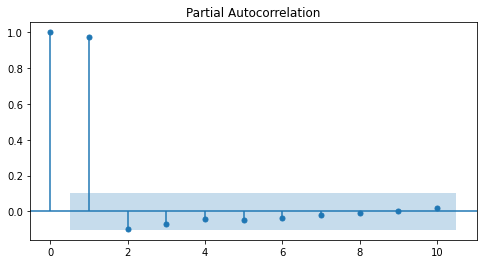

In [15]:
_,ax=plt.subplots(figsize=(8,4))
plot_pacf(data1t['Fan RPM mean'],lags=10,ax=ax);

In [16]:
# Exercise 8
# How many lags are needed? What is the vlaue of $p$?

Only the first lag is important, thus $p=1$.

If we would need to add MA terms, we can see from the autocorrelation plot how many lags are important, in this case about 20. However, as shown by the PACF plot, a model in which only the first lag is important can already explain the behavior of the system. The behavior can be probably explained by a first order (or larger) autocorrelation. We suspect at this point $d=1$.

<class 'pandas.core.series.Series'>


Tempo
2018-10-15 10:24:00    640.150000
2018-10-15 10:25:00    633.586207
2018-10-15 10:26:00    620.483871
2018-10-15 10:27:00    606.758621
2018-10-15 10:28:00    594.419355
Freq: T, Name: Fan RPM mean, dtype: float64

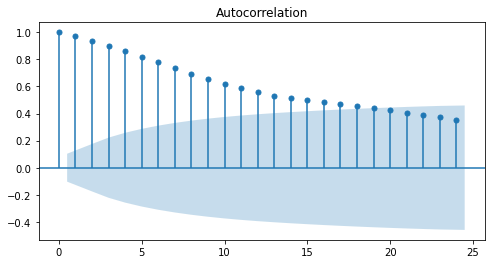

In [17]:
_,ax=plt.subplots(figsize=(8,4))
plot_acf(data1t['Fan RPM mean'],lags=np.arange(25),ax=ax);
print(type(data1t['Fan RPM mean']))
data1t['Fan RPM mean'].head()

So, we can make a first test with $p=1$ and $d=1$ and we will study the residuals, to understand if we need to increase the order of differentiation.

In [18]:
# There are some annoying warnings thrown by statsmodels when used in jupyter, this line silences them
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)

In [19]:
ts = data1t.loc[:,'Fan RPM mean']
fit=sm.tsa.ARIMA(ts,(1,1,0)).fit()
#warnings.resetwarnings()

In [20]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.Fan RPM mean   No. Observations:                  360
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1004.237
Method:                       css-mle   S.D. of innovations              3.933
Date:                Thu, 28 Oct 2021   AIC                           2014.474
Time:                        10:48:57   BIC                           2026.132
Sample:                    10-15-2018   HQIC                          2019.110
                         - 10-15-2018                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.0057      0.810      1.242      0.214      -0.581       2.593
ar.L1.D.Fan RPM mean     0.7459      0.035     21.128      0.000       0.677       0.815
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3406           +0.0000j            1.3406            0.0000
-----------------------------------------------------------------------------
"""

Let's now check the residuals of the model. If they are stationary we are good with a $d=1$ model.  
The residuals can be accessed via the `.resid` data member of the `fit` result object instance.

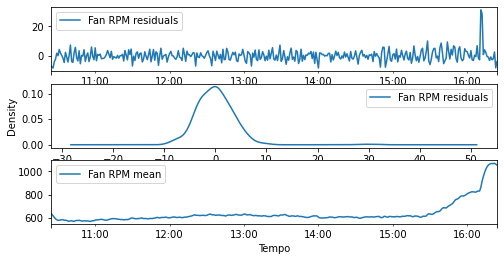

Fan RPM residuals
count         360.000000
mean            0.015683
std             3.950004
min            -8.461771
25%            -2.481763
50%            -0.065375
75%             2.144463
max            31.317041

In [21]:
tmp=pd.concat((data1t,pd.DataFrame(fit.resid,columns=["Fan RPM residuals"])),axis=1)
_,ax=plt.subplots(3,1,figsize=(8,4))
tmp[["Fan RPM residuals"]].plot(ax=ax[0])
tmp[["Fan RPM residuals"]].plot(kind='kde',ax=ax[1])
tmp[["Fan RPM mean"]].plot(ax=ax[2])
plt.show()
tmp[["Fan RPM residuals"]].describe()

## Forecast
Let's now verify the quality of the model ARIMA(1,1,0). To do that we split the data sample in two: data points after 11:00 will be used as test. We want to see the quality of the model 10 minutes in the future. 

In [22]:
# The model parameters
pdq=(1,1,0)

In [23]:
# Let's split the dataset in two
_start = np.datetime64("2018-10-15 11:00:00")
history = data1t.loc[:_start,["Fan RPM mean"]]
test = data1t.loc[_start+1:,["Fan RPM mean"]]
# Here are the steps we want to predict in the future: 10 minutes.
steps = 10

In [24]:
predictions=list()
for t in np.arange(len(test)):
    # First we fit the model to the initial small set of data
    fit=sm.tsa.ARIMA(history,pdq,freq="T").fit(disp=0)
    # And we forecast in the 10 future steps: this returns: 
    # for each step in the future the forecast value, the error and the aymmetric confidence intervals
    fc, stderr, conf_it=fit.forecast(steps)
    # We extract the last measurement and append it to th eresults
    predictions.append( (fc[-1],stderr[-1],conf_it[-1,0],conf_it[-1,1]) )

    # We extend now the history, adding one time step
    history=history.append(test.iloc[t:t+1])

# We evaluete the quality of the fit printing the MSE of the predictions on the test data set:
error=mean_squared_error(test,list(map(lambda x: x[0], predictions)))
pred_df = pd.DataFrame.from_records(predictions,index=test.index, columns=["Prediction","STDErr","CI_low","CI_high"])
print("Test MSE: %f"%error)

Test MSE: 127.753842


In [25]:
predictions=pd.concat((history,pred_df.shift(steps)),axis=1)
predictions["Residuals"]=(predictions["Prediction"]-predictions["Fan RPM mean"])

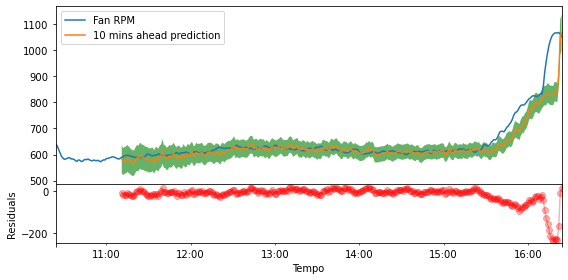

In [26]:
fig,(ax,ax2)=plt.subplots(2,1,figsize=(8,4),gridspec_kw={'height_ratios':[3,1],"hspace":0},sharex=True)
predictions[["Fan RPM mean"]].plot(ax=ax)
#predictions[["Prediction","STDErr"]].dropna().plot(ax=ax,yerr="STDErr")
predictions[["Prediction"]].plot(ax=ax)
ax.legend(["Fan RPM","10 mins ahead prediction"])
ax.fill_between(predictions.index.values,predictions["CI_high"],predictions["CI_low"],facecolor="green",alpha=.6)
ax.get_yaxis().set_label("RPM")
#ax.grid(axis="both")
predictions[["Residuals"]].plot(kind="line",ax=ax2,legend=None,marker='o',color='r',alpha=0.3)
plt.ylabel("Residuals")
#ax2.get_xaxis().set_ticks(np.arange(0,len(predictions),20))
fig.tight_layout()
plt.show()

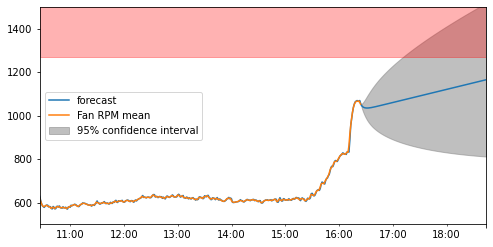

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.Fan RPM mean   No. Observations:                  360
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1004.237
Method:                       css-mle   S.D. of innovations              3.933
Date:                Thu, 28 Oct 2021   AIC                           2014.474
Time:                        10:49:15   BIC                           2026.132
Sample:                    10-15-2018   HQIC                          2019.110
                         - 10-15-2018                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.0057      0.810      1.242      0.214      -0.581       2.593
ar.L1.D.Fan RPM mean     0.7459      0.035     21.128      0.000       0.677       0.815
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3406           +0.0000j            1.3406            0.0000
-----------------------------------------------------------------------------
"""

In [27]:
fit = sm.tsa.ARIMA(data1t["Fan RPM mean"],pdq,freq="T").fit()
fig, ax = plt.subplots(figsize=(8,4))
#ax = data1t["Fan RPM mean"].plot(ax=ax)
fit.plot_predict(2,500,dynamic=False, ax=ax, plot_insample=True)
plt.axhspan(ymin=1270, ymax=1500, alpha=.3, color="r")
plt.ylim(500,1500)
plt.show()
fit.summary()

We can forecast to see how many time steps are necessary to reach the critical engine value of 1270. To be conservative we see when the forecast at the upper limit of the 95% CL reaches the critical value.  

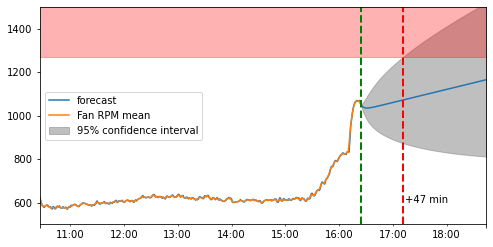

In [28]:
alpha = 0.05  #(1-.05=95%CL)
steps = 60*24 # 24 hours in the future, if more consider it to be inf
_, _ , ci = fit.forecast( steps, alpha = alpha)
time = np.min(np.where(ci[:,1]>1270)) #First time that we pass the threshold
fig, ax = plt.subplots(figsize=(8,4))
#ax = data1t["Fan RPM mean"].plot(ax=ax)
fit.plot_predict(2,500,dynamic=False, ax=ax, plot_insample=True)
plt.axhspan(ymin=1270, ymax=1500, alpha=.3, color="r")
plt.ylim(500,1500)
plt.axvline( data1t.index[-1], color='g',linestyle='--',linewidth=2.)
plt.axvline( pd.to_datetime(data1t.index[-1])+timedelta(minutes=int(time)),color='r',linestyle='--',linewidth=2.)
plt.text(data1t.index[-1]+timedelta(minutes=int(time+3)),600,"+%d min"%time)
plt.show()